In [3]:
import pandas as pd
import numpy as np

train = pd.read_csv(r"C:\Users\mahe\Downloads\train_kOBLwZA.csv")
test = pd.read_csv(r"C:\Users\mahe\Downloads\test_t02dQwI.csv")

In [4]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print(train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [5]:
print(train.shape)

(8523, 13)


In [6]:
data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [7]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [8]:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

In [9]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

F

In [10]:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

In [11]:
item_avg_weight

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


In [12]:
miss_bool = data['Item_Weight'].isnull()

In [13]:
miss_bool

0        False
1        False
2        False
3        False
4        False
         ...  
14199    False
14200    False
14201    False
14202    False
14203    False
Name: Item_Weight, Length: 14204, dtype: bool

In [14]:
print('Orignal #missing: %d'% sum(miss_bool))

Orignal #missing: 2439


In [15]:
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])

In [16]:
print('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Final #missing: 0


In [17]:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print('Mode for each Outlet_Type:')
print(outlet_size_mode)

Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [18]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print(sum(data['Outlet_Size'].isnull()))


Orignal #missing: 4016
0


In [19]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.loc[x])
print('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [20]:
#Determine another variable with means ratio
data['Item_Visibility_meanratio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg.loc[x['Item_Identifier']],axis=1)

In [21]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Visibility_meanratio
count,14204.000000,14204.000000,14204.000000,14204.000000,8523.000000,14204.000000
mean,12.793380,0.069710,141.004977,1997.830681,2181.288914,1.061884
std,4.651716,0.049728,62.086938,8.371664,1706.499616,0.235907
min,4.555000,0.003575,31.290000,1985.000000,33.290000,0.844563
25%,8.710000,0.031145,94.012000,1987.000000,834.247400,0.925131
50%,12.600000,0.057194,142.247000,1999.000000,1794.331000,0.999070
75%,16.750000,0.096930,185.855600,2004.000000,3101.296400,1.042007
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,3.010094


In [22]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [23]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [24]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [25]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [26]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [27]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [28]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Item_Visibility_meanratio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
O

In [29]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


In [30]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Outlet_Identifier             object
Item_Outlet_Sales            float64
source                        object
Item_Visibility_meanratio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_0                       uint8
Outlet_1                       uint8
O

In [31]:
#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

In [32]:
#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

c:\users\mahe\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

In [34]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

In [35]:
#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]

In [36]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import model_selection, metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
    print(alg.score(dtrain[predictors], dtrain[target]))
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = model_selection.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

0.5631348055105607

Model Report
RMSE : 1128
CV Score : Mean - 1129 | Std - 43.46 | Min - 1074 | Max - 1211


<ipython-input-36-03395aa5b580>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


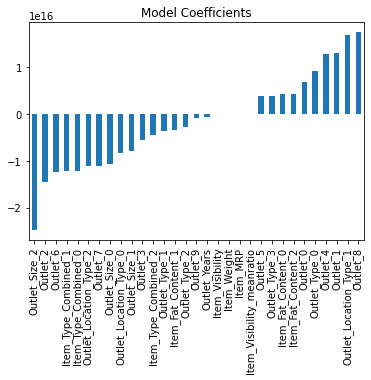

In [37]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

0.5625404650408207

Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217


<ipython-input-36-03395aa5b580>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


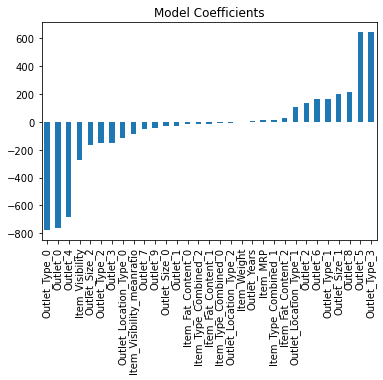

In [38]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

0.6157992263916037

Model Report
RMSE : 1058
CV Score : Mean - 1091 | Std - 45.42 | Min - 1003 | Max - 1186


<ipython-input-36-03395aa5b580>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


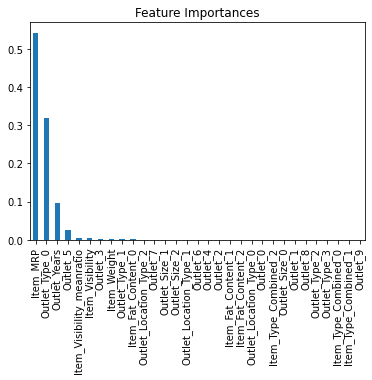

In [39]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

0.6058974644993484

Model Report
RMSE : 1071
CV Score : Mean - 1096 | Std - 43.3 | Min - 1027 | Max - 1172


<ipython-input-36-03395aa5b580>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


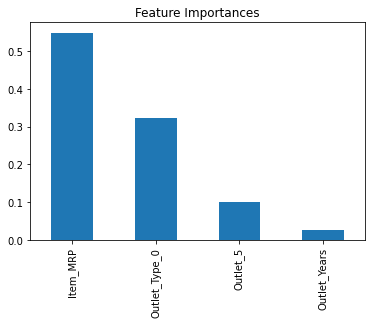

In [40]:
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

0.6042778915285709

Model Report
RMSE : 1073
CV Score : Mean - 1083 | Std - 43.52 | Min - 1020 | Max - 1161


<ipython-input-36-03395aa5b580>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


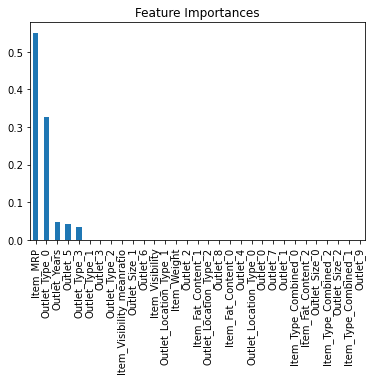

In [43]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

0.6079838241359734

Model Report
RMSE : 1068
CV Score : Mean - 1083 | Std - 43.55 | Min - 1020 | Max - 1161


<ipython-input-36-03395aa5b580>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest[target] = alg.predict(dtest[predictors])


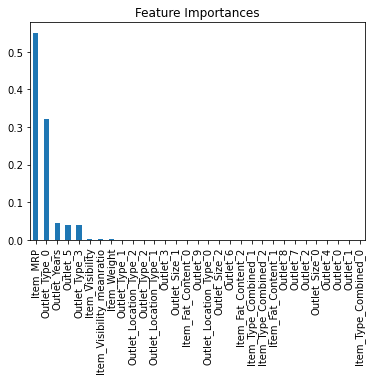

In [44]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg6, train, test, predictors, target, IDcol, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')